In [92]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
import numpy as np
import pandas as pd
import networkx as nx

%matplotlib inline
ox.__version__

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [93]:
nodes = gpd.read_file("data/graph/nodes.shp")
edges = gpd.read_file("data/graph/edges.shp")

In [94]:
categories = ["education", "bank", "healthcare", "transportation", "food" ]

#initialize all entries to False
for category in categories:
    nodes[category] = False

#if the node is a POI then set its entries to True
"""for index, node in nodes.iterrows():
    if node["POI"] in categories:
        for category in categories:
            nodes.at[index, category] = True"""

'for index, node in nodes.iterrows():\n    if node["POI"] in categories:\n        for category in categories:\n            nodes.at[index, category] = True'

In [95]:
nodes = nodes.set_index("osmid")
edges = edges.set_index(['u', 'v', 'key'])

G = ox.utils_graph.graph_from_gdfs(nodes, edges)

<h1>Coverage</h1>
<p>Given a graph G = (nodes, edges) knowing that in the edges there are some POIs, modify the nodes table to have that: nodes below 15 minutes to at least a POI of a certain category have that category column set to true.</p>
<p>Example: Suppose node i is below 15 minutes to 2 schools, 4 supermarkets and nothing more, then these will be its column values</p>
<table>
  <tr>
    <th>education</th>    
    <th>bank</th>
    <th>healthcare</th>
    <th>transportation</th>    
    <th>food</th>
  </tr>
  <tr>
    <td>True</td>
    <td>False</td>
    <td>False</td>
    <td>False</td>
    <td>True</td>
  </tr>

In [96]:
travel_speed = 5  # walking speed in km/hour

# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [97]:
nodes, edges = ox.graph_to_gdfs(G)
edges.head()

osmid                     highway  oneway  \
u v   key                                                              
0 235 0                244968982                        path       0   
      1                 41224006                    tertiary       0   
      2    [23516585, 960693916]  ['residential', 'footway']       0   
      3                244969034                        path       0   
  233 0                244969016                        path       0   

                reversed      length  from   to width  u_original  v_original  \
u v   key                                                                       
0 235 0            False  262.005714     0  235     3   254672751  1706766353   
      1            False  205.686533     0  235   NaN   254672878  2796391751   
      2    [False, True]  269.826579     0  235   NaN  2522360919  2522409502   
      3             True  219.053507     0  235     3  2522360919  2522360929   
  233 0            False  269.193872     0  233   2.5   243488899  2522360913   

                                                    geometry      time lanes  \
u v   key                                                                      
0 235 0    LINESTRING (724701.900 5034203.206, 724666.149...  3.144069   NaN   
      1    LINESTRING (724701.900 5034203.206, 724674.181...  2.468238     2   
      2    LINESTRING (724701.900 5034203.206, 724686.435...  3.237919   NaN   
      3    LINESTRING (724701.900 5034203.206, 724678.669...  2.628642   NaN   
  233 0    LINESTRING (724714.668 5034196.773, 724771.919...  3.230326   NaN   

                              name maxspeed tunnel bridge access est_width  \
u v   key                                                                    
0 235 0                        NaN      NaN    NaN    NaN    NaN       NaN   
      1    Via Annibale da Bassano      NaN    NaN    NaN    NaN       NaN   
      2    Via Annibale da Bassano      NaN    NaN    NaN    NaN       NaN   
      3                        NaN      NaN    NaN    NaN    NaN       NaN   
  233 0                        NaN      NaN    NaN    NaN    NaN       NaN   

          service area  ref junction  
u v   key                             
0 235 0       NaN  NaN  NaN      NaN  
      1       NaN  NaN  NaN      NaN  
      2       NaN  NaN  NaN      NaN  
      3       NaN  NaN  NaN      NaN  
  233 0       NaN  NaN  NaN      NaN

In [98]:
#edges = ox.graph_to_gdfs(G, nodes=False)

#G = ox.graph_from_gdfs(nodes, edges)

<h2>Plot graph with all POIs</h2>
<p>We will plot a graph with red nodes representing normal nodes and blue nodes representing POIs</p>

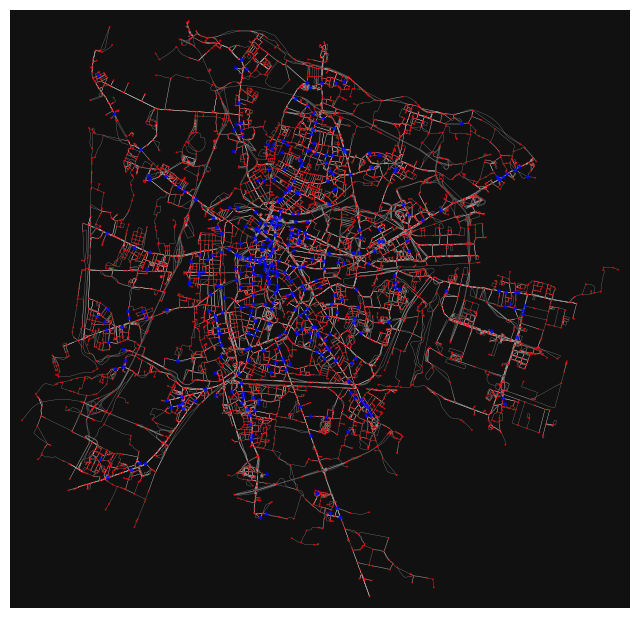

In [99]:
## color the nodes: red - normal; blue - POIs
node_colors = {}
node_sizes = {}
for node, data in G.nodes(data=True):
    node_id = node
    poi = data.get("POI", None)
    if poi in categories:
        node_colors[node_id] = "blue"
        node_sizes[node_id] = 8
    else:
        node_colors[node_id] = "red"
        node_sizes[node_id] = 1.8
        
        
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [node_sizes[node] if node in node_sizes else "none" for node in G.nodes()]

fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

<h2>Plot subgraphs with close nodes for each category</h2>
<p>Plot multiple graphs (one for each category) where blue nodes are POIs, green nodes are the ones near to at least a POI, i.e. covered, red are uncovered nodes (>15 min).</p>

In [100]:
#Create a list of POIs for each category
poi_nodes = {}
for category in categories:
    poi_nodes[category] = []
for node, data in G.nodes(data=True):
    node_id = node
    poi = data.get("POI", None)
    if poi in categories:
        poi_nodes[poi].append(node_id)

In [101]:
#Compute a subgraph of covered nodes for each category
trip_time = 15
subgraph_nodes = {}
for category in categories:
    subgraph_nodes[category] = []
    for poi_id in poi_nodes[category]:
        subgraph = nx.ego_graph(G, poi_id, radius=trip_time, distance="time", undirected=True)
        for n in subgraph.nodes():
            subgraph_nodes[category].append(n)

for c in categories:
    print(len(subgraph_nodes[c]))


7476
5588
6530
1864
9139


In [102]:
#Update nodes table with coverage results
for index, node in nodes.iterrows():
    for category in categories:
        if(index in subgraph_nodes[category]):
            nodes.at[index, category] = True

<h3>Print graph with covered nodes for each category</h3>

In [103]:
def printCoveredNodes(poi_cat):
    node_colors = []
    covered_cnt = 0
    uncovered_cnt = 0
    for index, node in nodes.iterrows():
        if nodes.at[index, poi_cat] == True:
            node_colors.append("green")  
            covered_cnt += 1
        else:
            node_colors.append("red")
            uncovered_cnt += 1
            
    print("Number of covered nodes (green): ", covered_cnt)
    fig, ax = ox.plot_graph(
        G,
        node_color=node_colors,
        node_size=4,
        node_alpha=0.8,
        edge_linewidth=0.2,
        edge_color="#999999",
    )

Printing graph of covered nodes from  education
Number of covered nodes (green):  3273


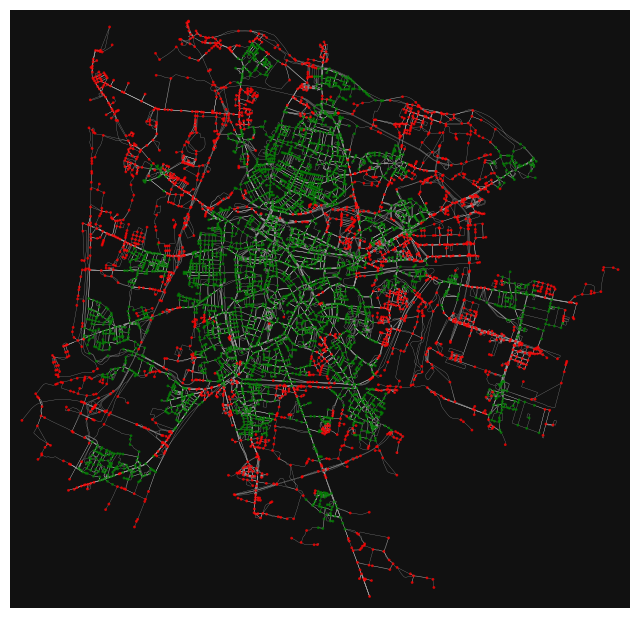

Printing graph of covered nodes from  bank
Number of covered nodes (green):  1995


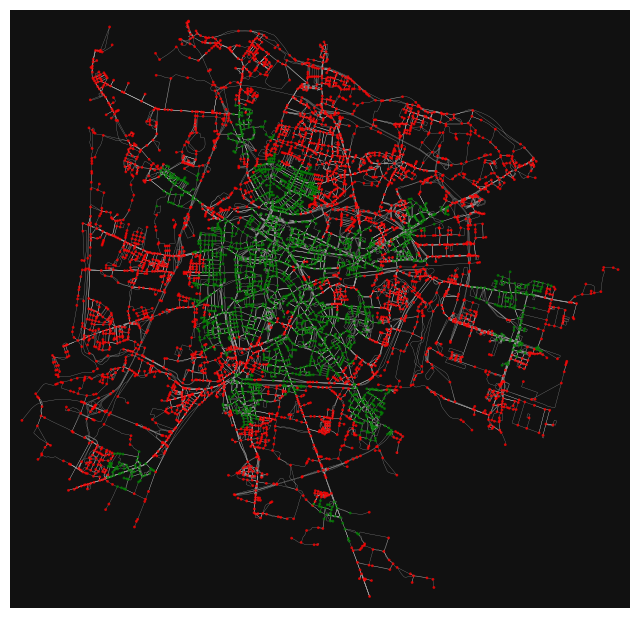

Printing graph of covered nodes from  healthcare
Number of covered nodes (green):  2926


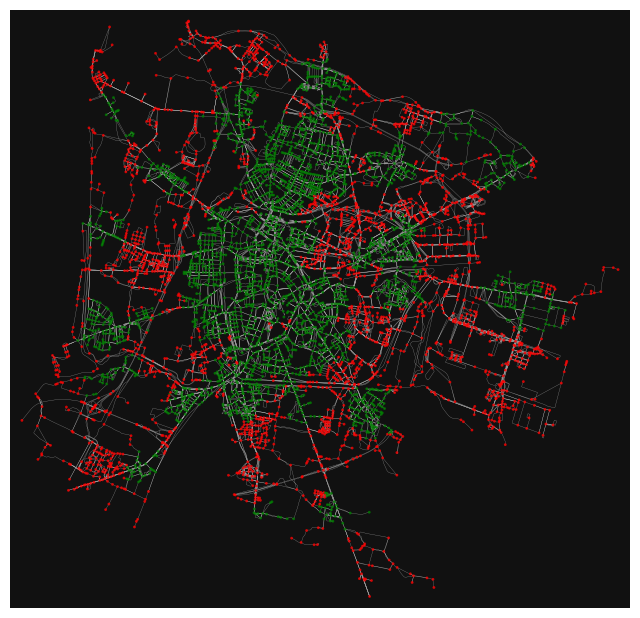

Printing graph of covered nodes from  transportation
Number of covered nodes (green):  1045


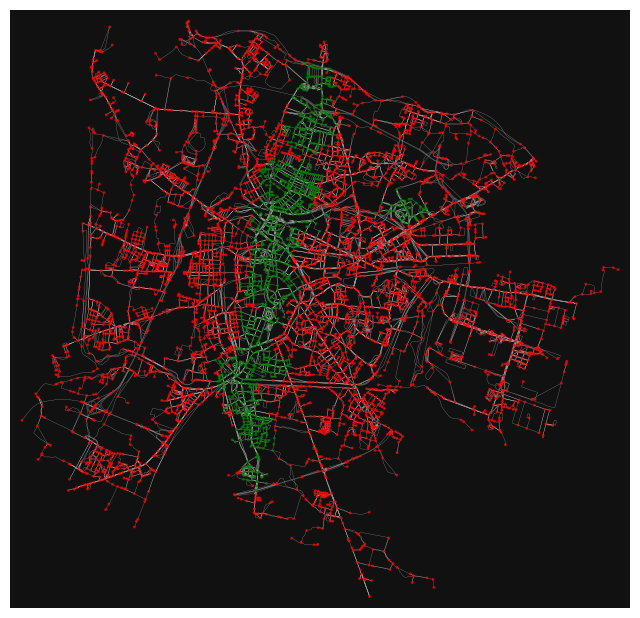

Printing graph of covered nodes from  food
Number of covered nodes (green):  3669


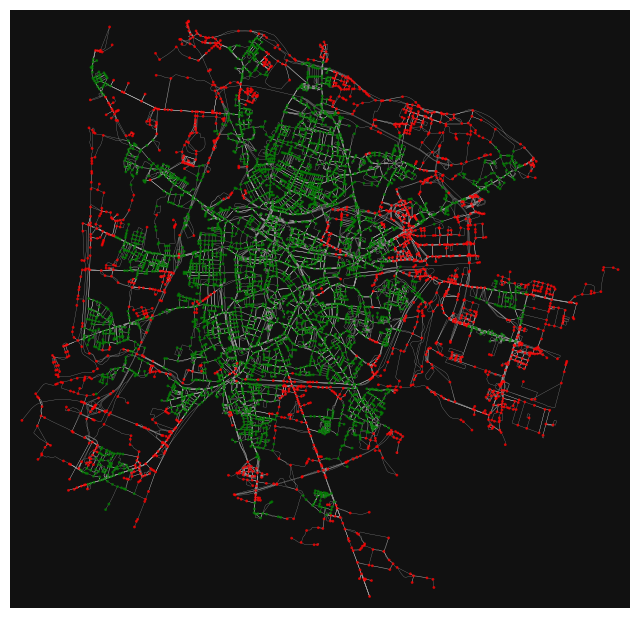

In [104]:
for c in categories:
    print("Printing graph of covered nodes from " , c)
    printCoveredNodes(c)